<a href="https://colab.research.google.com/github/yatindma/Automated-Response-Suggestion-for-Email/blob/master/Smart_email_reply_suggestion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Smart Email Reply Suggestion

In this case study,<br> we have to suggest 3 replies to the user,<br> so that user need not to type the reply

In [0]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K

In [47]:
# Load the Drive helper and mount
from google.colab import drive
# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Reading the data

In [0]:

#Reading email dataset
data = pd.read_csv('qa_dataset.csv', encoding = "ISO-8859-1", low_memory=False)
#Dropping unused data from the dataframe 
data = data.drop(['ArticleTitle','DifficultyFromQuestioner','DifficultyFromAnswerer','ArticleFile'],axis =1 ) 
#Changing teh name of teh collumns
data.columns = ['question','reply']

In [49]:
data.head()

,question,reply
0,Was Volta an Italian physicist?,yes
1,Is Volta buried in the city of Pittsburgh?,no
2,Did Volta have a passion for the study of elec...,yes
3,What is the battery made by Volta credited to be?,the first cell
4,What important electrical unit was named in ho...,the volt


Converting data into lower case

In [50]:
data = data.apply(lambda x: x.astype(str).str.lower())
data.head(4)

,question,reply
0,was volta an italian physicist?,yes
1,is volta buried in the city of pittsburgh?,no
2,did volta have a passion for the study of elec...,yes
3,what is the battery made by volta credited to be?,the first cell


Removing all special characters from the data

In [51]:
import re
all_questions = []
for sentence in data.question:
   all_questions.append(re.sub('[^A-Za-z0-9]+', ' ', sentence))
print(all_questions[:3]) # to check wheather the removal code didn' effected the data

['was volta an italian physicist ', 'is volta buried in the city of pittsburgh ', 'did volta have a passion for the study of electricity ']


In [0]:
#Putting all preprocessed data back to the dataframe
data['question'] = all_questions

Trimming the data

In [0]:
data = data.applymap(lambda x: x.strip() if isinstance(x, str) else x)

Dropping Duplicate questions from the data

In [0]:
data.drop_duplicates(subset ="question", keep = False, inplace = True) 

Remove the data from which are having more than 20 words

In [55]:
temp_arr = data["reply"].str.len()
# get the average of the length of the replies
total = sum(temp_arr)
average_length = total / len(temp_arr)
print("average length of the replies",int(average_length))

average length of the replies 17


so after seeing the average length of the we'll choose max length i.e 20

In [56]:
#get the length of the replies
data["reply_length"]= data["reply"].str.len()

data = data[(data.reply_length < 20)]
print(data.head())

                                            question  ... reply_length
0                     was volta an italian physicist  ...            3
1          is volta buried in the city of pittsburgh  ...            2
2  did volta have a passion for the study of elec...  ...            3
3   what is the battery made by volta credited to be  ...           14
6                   where did volta enter retirement  ...            5

[5 rows x 3 columns]


**DATA VISUALIZATION**

In [0]:
reply_list = list(data['reply'].values)
cleaned_replies = []
for sentence in reply_list:
   cleaned_replies.append(re.sub('[^A-Za-z0-9]+', ' ', sentence))

reply_dict = {i:reply_list.count(i) for i in cleaned_replies}

In [0]:
from collections import OrderedDict
reply_dict_sorted = OrderedDict(sorted(reply_dict.items(), key=lambda x: x[1]))

In [0]:
reply = []
keys = []
for item in reply_dict_sorted.items():
  reply.append(item[0])
  keys.append(item[1])

In [0]:
reply.reverse()
keys.reverse()

In [0]:
#top 10 reply
top_5_reply = reply[:5]
top_5_keys = keys[:5]

In [0]:
temp_reply_list = []
i = 0
for key in top_5_keys:
  for _ in range(0,key):
    temp_reply_list.append(top_5_reply[i])
  i += 1

<b>
Article title can be used while giving the sentence for tokenizing later 
question do we need to preprocess the data
reply mai kitne repeated h
</b>


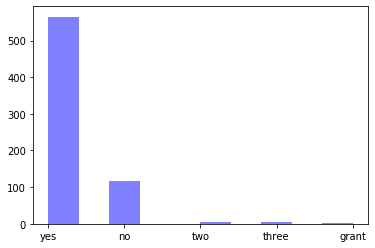

In [84]:
plt.hist(temp_reply_list, 10,
         histtype='bar',
         facecolor='b',
         alpha=0.5)
plt.show()

From the above graph we can observe that 
<b>yes</b> and <b>no</b> reply are the most common reply in the mails

In [0]:
#all the words 
# Vocabulary of questions
all_email_words=[]
for quest in data['question'].values:
    for word in quest.split():
        if word not in all_email_words:
            all_email_words.append(word)


Tokenize the sentence

In [65]:
#All input words

input_words = sorted(list(all_email_words))

# get the length of the vocabalary // Kitne words // this will help while performing embedding layer
num_encoder_tokens = len(all_email_words) + 1
vocab_len = num_encoder_tokens
print(vocab_len)

2988


**Dictionary to get token from the word**

In [0]:
# from word to token we can get
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])

**Dictionary to get word from the token**

In [0]:
#Will not be used here
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())

**We'll tokenize the sentence itself for replies**

In [68]:
tokenized_reply_sentences = []
# need to get all the unique replies in the dataset

all_unique_replies = list(set(data['reply'].values))
print('unique replies in the data',len(all_unique_replies))

unique replies in the data 355


In [0]:
output_words = sorted(list(all_unique_replies))
# from word to token we can get
output_token_index = dict([(word, i+1) for i, word in enumerate(output_words)])

In [70]:
output_token_index['the duck']

314

In [0]:

reverse_output_index = dict((i, word) for word, i in output_token_index.items())

**Divide the data into train and test**

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data['question'], data['reply'], test_size = 0.1, random_state = 42)
#we have given only 10% of the data for the testing as already we have very less data

In [73]:
#Checking number of unique replies that dataset contain
all_unique_replies = list(set(data['reply'].values))
print('unique replies in the data',len(all_unique_replies))

all_unique_replies_train = list(set(y_train.values))
print('unique replies in the train data',len(all_unique_replies_train))

all_unique_replies_test = list(set(y_test.values))
print('unique replies in the test data',len(all_unique_replies_test))

unique replies in the data 355
unique replies in the train data 327
unique replies in the test data 41


Need to check how many sentences which are there in test replies but are not present in the train data 

In [74]:
replies_in_test_not_available_in_train_set = len(all_unique_replies) - len(all_unique_replies_train)
print("Replies not available in train data",replies_in_test_not_available_in_train_set)

Replies not available in train data 28


In [0]:
def generate_batch(X,y, batch_size):
    while True:
        for j in range(0, len(X), batch_size):
                    encoder_input_data = np.zeros((batch_size, vocab_len),
                            dtype='float32')
                    rows, cols = (len(y), len(all_unique_replies)) 
                    # output_data = [[0]*cols]*rows 
                    output_data = np.zeros((rows, cols),
                            dtype='float32')
                    for (i, (input_text, target_text)) in enumerate(zip(X[j:j+ batch_size], y[j:j + batch_size])):

                        # for words in each sentence //question
                        for (t, word) in enumerate(input_text.split()):  # question wale text ko tokenize kiya gaya
                            encoder_input_data[i,t] = input_token_index[word]  # encoder input seq
                        #For replies we are creating this
                        
                        ##output_data[i,output_token_index[target_text]] = 1
                        output_data[i][output_token_index[target_text]-1] = 1
                    return (encoder_input_data,output_data)

Glove Vector

In [0]:
import pickle
glove_pickel = open("drive/My Drive/DonarChoose/glove_vectors","rb")
glove_ = pickle.load(glove_pickel)

In [0]:
vector = glove_.get(word)

In [30]:
embedded_matrix = np.zeros((vocab_len, 300))
for word, i in input_token_index.items():
    vector = glove_.get(word)
    if vector is not None:
      embedded_matrix[i] = vector
print(embedded_matrix.shape)

(2988, 300)


#Create model 

In [31]:
#https://stackoverflow.com/questions/56097089/how-to-fix-name-embedding-is-not-defined-in-keras
from keras.layers import Dense, Dropout, BatchNormalization, Input, Flatten, concatenate,Embedding,RepeatVector
latent_dim = 300
embedded_layer = Embedding(vocab_len,latent_dim,weights=[embedded_matrix],input_length=vocab_len,trainable=False) # we are using the embedded matrix to get the weights which we initialize randomly in embedded layer

Using TensorFlow backend.


In [34]:
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional,Concatenate,TimeDistributed
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model, Sequential

 # how much dimension of output we want form the embedding layer
encoder_inputs = Input(shape=(None,)) # mentioning the input shape row and collumns are still null
model = Sequential()
model.add(embedded_layer)
model.add(Bidirectional(LSTM(128))) # return a single vector of 100 dimension
model.add(Dropout(0.3))
model.add(Dense(355, activation='sigmoid')) #355 because we have 355 unique replies in the data
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
x,y = generate_batch(x_train,y_train,len(x_train))

In [39]:
# model.fit(x,y)
model.fit(x, y,
          batch_size=100,
          epochs=5)

Epoch 1/5
1029/1029 [==============================] - 94s 91ms/step - loss: 0.4548 - acc: 0.9373
Epoch 2/5
1029/1029 [==============================] - 94s 91ms/step - loss: 0.1310 - acc: 0.9968
Epoch 3/5
1029/1029 [==============================] - 93s 91ms/step - loss: 0.0359 - acc: 0.9971
Epoch 4/5
1029/1029 [==============================] - 93s 90ms/step - loss: 0.0176 - acc: 0.9971
Epoch 5/5
1029/1029 [==============================] - 94s 91ms/step - loss: 0.0136 - acc: 0.9971


In [0]:
def generate_batch_test(X,y):
    while True:
        for j in range(0, len(X), 1):
                    encoder_input_data = np.zeros((1, vocab_len),
                            dtype='float32')
                    rows, cols = (len(y), len(all_unique_replies)) 
                    # output_data = [[0]*cols]*rows 
                    output_data = np.zeros((rows, cols),
                            dtype='float32')
                    for (i, (input_text, target_text)) in enumerate(zip(X[j:j+ 1], y[j:j + 1])):

                        # for words in each sentence //question
                        for (t, word) in enumerate(input_text.split()):  # question wale text ko tokenize kiya gaya
                            encoder_input_data[i,t] = input_token_index[word]  # encoder input seq

                        return encoder_input_data

In [45]:
index = 0
test_question = generate_batch_test(x_test.values[index],y_test.values[index])
output_token = model.predict(test_question)

#first reply #Taking first reply from the array what model has predicted 
sampled_token_index_1 = np.argmax(output_token)
#Making highest probability as 0 so that next time we can get the 2nd highest probabily
output_token[0][sampled_token_index_1] = 0

#second reply
sampled_token_index_2 = np.argmax(output_token)
output_token[0][sampled_token_index_2] = 0 # making second the probability 0 so that we can get third heighest probabilty

#Third reply
sampled_token_index_3 = np.argmax(output_token)
output_token[0][sampled_token_index_3] = 0

print('question is : ',x_test.values[index])
for i in range(0,3):
  print('reply',i+1 ,reverse_output_index[i+1])



question is :  is rainfall very low
reply 1 (bad question)
reply 2 (what?)
reply 3 *shrug*


Approach:

1.   First we took the data and cleaned it
2.   We tokenized each question(words/vocab) and we got one matrix for questions
3.   Again I tokenized replies(full unique sentence has one token) <br> **eg. [how are you : 23],<br>    [Is it raining : 53]**
4.   We gave the x_train question matrix as a tokenized and padded and for replies we have matrix for each sentence and passed it to the model
5.   Model gave 99.7% accuracy



Reference:<br>
[Gabriel farah QA bot](https://github.com/gabrielfarah/QA_Bot)
<br>
[Google smart reply suggestions](https://arxiv.org/pdf/1606.04870.pdf)<br>
[StackOverflow](https://www.stackoverflow.com)




> ### ### ###  Thank You ### ### ###
